In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1366900


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.034824,0.028238,0.038251,0.032876,0.032876,0.260244
1,0.023479,0.016289,0.033543,0.026255,0.026255,0.272327
2,0.006289,0.016708,0.024522,0.026144,0.026144,0.305026
3,0.030991,0.031853,0.047945,0.046805,0.046805,0.211213
4,0.040212,0.042518,0.056083,0.054858,0.054858,0.173974


In [4]:
timestamp = 5
epoch = 500
future_day = 50

In [5]:
def embed_seq(
    inputs, vocab_size = None, embed_dim = None, zero_pad = False, scale = False
):
    lookup_table = tf.compat.v1.get_variable(
        'lookup_table', dtype = tf.float32, shape = [vocab_size, embed_dim]
    )
    if zero_pad:
        lookup_table = tf.concat(
            (tf.zeros([1, embed_dim]), lookup_table[1:, :]), axis = 0
        )
    outputs = tf.nn.embedding_lookup(params=lookup_table, ids=inputs)
    if scale:
        outputs = outputs * (embed_dim ** 0.5)
    return outputs


def learned_positional_encoding(
    inputs, embed_dim, zero_pad = False, scale = False
):
    T = inputs.get_shape().as_list()[1]
    outputs = tf.range(T)
    outputs = tf.expand_dims(outputs, 0)
    outputs = tf.tile(outputs, [tf.shape(input=inputs)[0], 1])
    return embed_seq(outputs, T, embed_dim, zero_pad = zero_pad, scale = scale)


def layer_norm(inputs, epsilon = 1e-8):
    mean, variance = tf.nn.moments(x=inputs, axes=[-1], keepdims = True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.compat.v1.get_variable(
        'gamma', params_shape, tf.float32, tf.compat.v1.ones_initializer()
    )
    beta = tf.compat.v1.get_variable(
        'beta', params_shape, tf.float32, tf.compat.v1.zeros_initializer()
    )
    return gamma * normalized + beta


def pointwise_feedforward(inputs, num_units = [None, None], activation = None):
    outputs = tf.compat.v1.layers.conv1d(
        inputs, num_units[0], kernel_size = 1, activation = activation
    )
    outputs = tf.compat.v1.layers.conv1d(
        outputs, num_units[1], kernel_size = 1, activation = None
    )
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


class Model:
    def __init__(
        self,
        dimension_input,
        dimension_output,
        seq_len,
        learning_rate,
        num_heads = 8,
        attn_windows = range(1, 6),
    ):
        self.size_layer = dimension_input
        self.num_heads = num_heads
        self.seq_len = seq_len
        self.X = tf.compat.v1.placeholder(tf.float32, [None, seq_len, dimension_input])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, dimension_output])
        feed = self.X
        for i, win_size in enumerate(attn_windows):
            with tf.compat.v1.variable_scope('attn_masked_window_%d' % win_size):
                feed = self.multihead_attn(feed, self.window_mask(win_size))
        feed += learned_positional_encoding(feed, dimension_input)
        with tf.compat.v1.variable_scope('multihead'):
            feed = self.multihead_attn(feed, None)
        with tf.compat.v1.variable_scope('pointwise'):
            feed = pointwise_feedforward(
                feed,
                num_units = [4 * dimension_input, dimension_input],
                activation = tf.nn.relu,
            )
        self.logits = tf.compat.v1.layers.dense(feed, dimension_output)[:, -1]
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        self.correct_pred = tf.equal(
            tf.argmax(input=self.logits, axis=1), tf.argmax(input=self.Y, axis=1)
        )
        self.accuracy = tf.reduce_mean(input_tensor=tf.cast(self.correct_pred, tf.float32))

    def multihead_attn(self, inputs, masks):
        T_q = T_k = inputs.get_shape().as_list()[1]
        Q_K_V = tf.compat.v1.layers.dense(inputs, 3 * self.size_layer, tf.nn.relu)
        Q, K, V = tf.split(Q_K_V, 3, -1)
        Q_ = tf.concat(tf.split(Q, self.num_heads, axis = 2), axis = 0)
        K_ = tf.concat(tf.split(K, self.num_heads, axis = 2), axis = 0)
        V_ = tf.concat(tf.split(V, self.num_heads, axis = 2), axis = 0)
        align = tf.matmul(Q_, tf.transpose(a=K_, perm=[0, 2, 1]))
        align = align / np.sqrt(K_.get_shape().as_list()[-1])
        if masks is not None:
            paddings = tf.fill(tf.shape(input=align), float('-inf'))
            align = tf.compat.v1.where(tf.equal(masks, 0), paddings, align)
        align = tf.nn.softmax(align)
        outputs = tf.matmul(align, V_)
        outputs = tf.concat(
            tf.split(outputs, self.num_heads, axis = 0), axis = 2
        )
        outputs += inputs
        return layer_norm(outputs)

    def window_mask(self, h_w):
        masks = np.zeros([self.seq_len, self.seq_len])
        for i in range(self.seq_len):
            if i < h_w:
                masks[i, : i + h_w + 1] = 1.0
            elif i > self.seq_len - h_w - 1:
                masks[i, i - h_w :] = 1.0
            else:
                masks[i, i - h_w : i + h_w + 1] = 1.0
        masks = tf.convert_to_tensor(value=masks)
        return tf.tile(
            tf.expand_dims(masks, 0),
            [tf.shape(input=self.X)[0] * self.num_heads, 1, 1],
        )

In [6]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
modelnn = Model(
    df_log.shape[1],
    df_log.shape[1],
    timestamp,
    0.01,
    num_heads = df_log.shape[1],
)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:202: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  warnings.warn('`tf.layers.conv1d` is

In [7]:
for i in range(epoch):
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(
            df_log.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : k + timestamp + 1].values
        _, loss = sess.run(
            [modelnn.optimizer, modelnn.cost],
            feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
        )
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.030373856328421822
epoch: 200 avg loss: 0.03037342562426765
epoch: 300 avg loss: 0.030351626272432698
epoch: 400 avg loss: 0.030677828259500436
epoch: 500 avg loss: 0.030353629004168443


In [8]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp

for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 0)
        },
    )
    output_predict[k + 1 : k + timestamp + 1] = out_logits

df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [9]:
for i in range(future_day - 1):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0)
        },
    )
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [10]:
df_log = minmax.inverse_transform(df_log.values)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [11]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

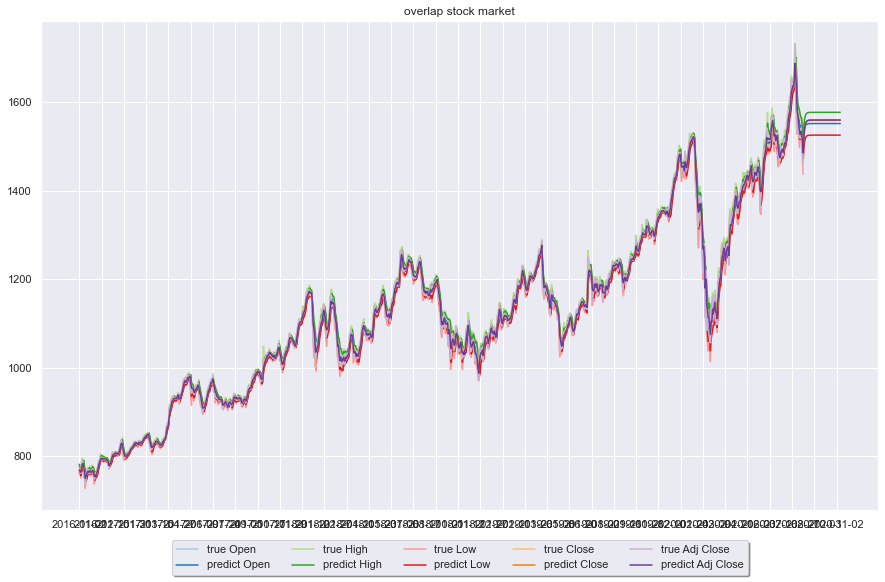

In [12]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

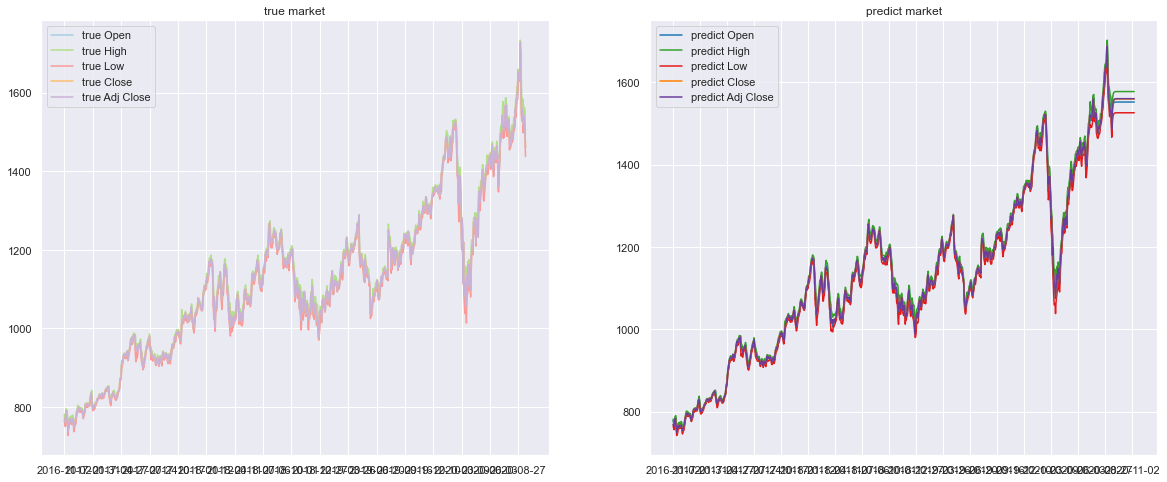

In [13]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

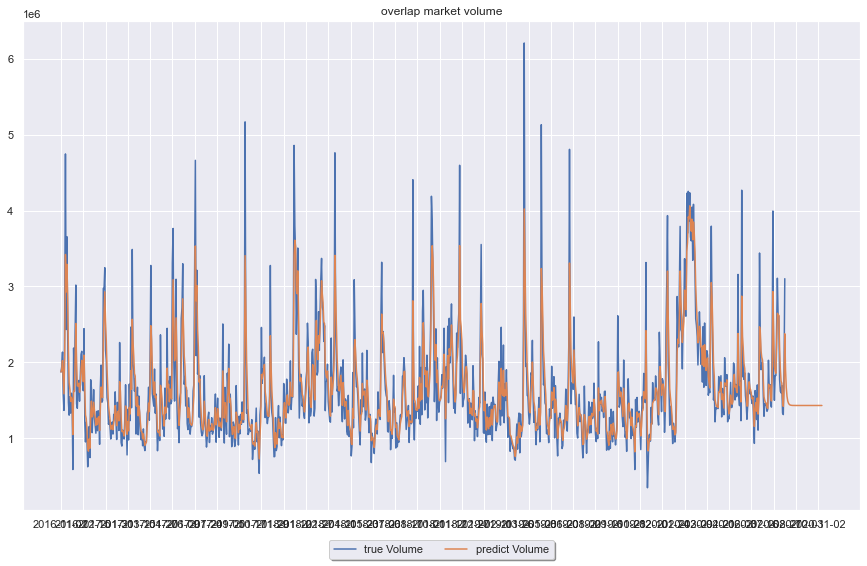

In [14]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

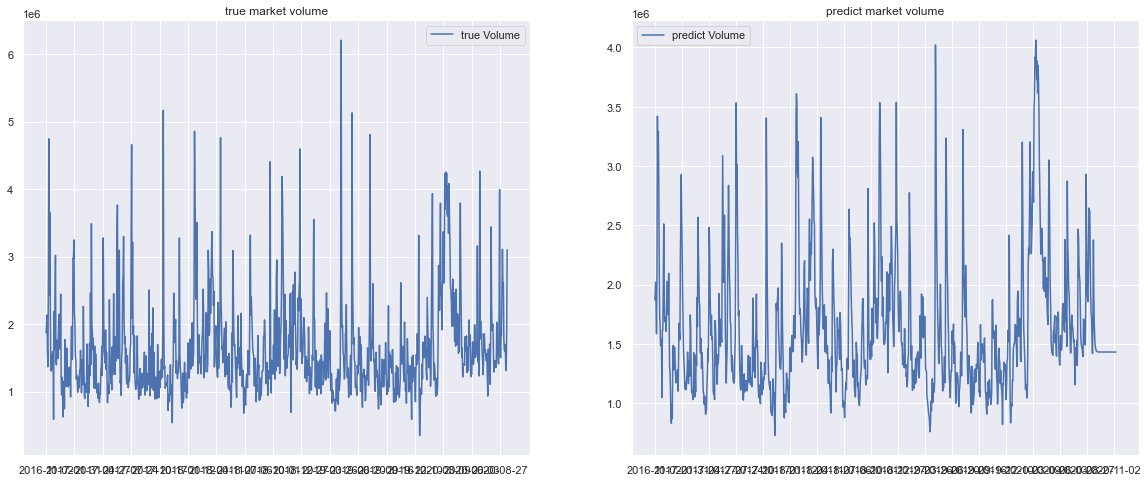

In [15]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()